In [1]:
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
### Set up the pauli ops
I,X,Y,Z = np.matrix([[1,0],[0,1]]),np.matrix([[0,1],[1,0]]),np.matrix([[0,-1j],[1j,0]]),np.matrix([[1,0],[0,-1]])
[X0,Y0,Z0] = [np.kron(op,I) for op in [X,Y,Z]]
[X1,Y1,Z1] = [np.kron(I,op) for op in [X,Y,Z]]

In [3]:
from scipy.linalg import expm
def evolve(pulses, dt, H0, H_ops):
    """
    Compute the operator associated with a set of pulses
    
    (List[List[Float]]) pulses: The pulses. Each element should have length equal length
    (Float) dt: duration of each pulse
    (np.matrix) H0: The drift Hamiltonian
    (List[np.matrix]) H_ops: The control Hamiltonians.
    """
    U = np.identity(len(H0))
    for i in range(len(pulses[0])): 
        H = H0
        for k in range(len(pulses)):
            H = H + pulses[k][i] * H_ops[k]
        U=expm(-1j * dt * H) @ U
    return U
def getFidelity(dt, H0, H_ops,target):
    """
    Get an optimizable fidelity function for a set of pulses
    (Float) dt: Time increment
    (np.matrix) H0: The drift Hamiltonian
    (List[np.matrix]) H_ops: The control Hamiltonians.
    (np.matrix) target: The target state
    """
    def loss(coeffs):
        global iterations
        pulses = np.split(coeffs,len(H_ops))
        U=evolve(pulses, dt, H0, H_ops)
        fidelity = np.abs(np.trace(U.conjugate().transpose()@target))/len(target)
        return  -1 * fidelity 
    return loss 

In [4]:
import scipy
###Control and drift
H_ops = [Z0,X0,Y1,Z0@X1]
H_labels = [r'$Z_{0}$', r'$X_{0}$', r'$Y_{1}$', r'$Z_{0}X_1$']
H0 = Z0+Z1
CNOT = [[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]]

T=2*np.pi
N = 10 #number of individual steps
dt  = T/N #time interval for each step

u0 = np.random.rand(N*len(H_ops)) * 2 * np.pi * 0.05 #make a random array to start out
u0=np.convolve(np.ones(10)/10, u0,mode='same') #smooths the input
result = scipy.optimize.minimize(fun = getFidelity(dt=dt, H0=H0, H_ops=H_ops,target=CNOT)
                    ,x0=u0, bounds = [[-10,10]]*N*len(H_ops)
                 )
print("CNOT Fidelity: "+str(-1 * result.fun))

CNOT Fidelity: 0.9999999508258792


In [5]:
###The parameterized lookup table we want
def excitation(theta):
    return expm(1j * theta/2 * (X0@ Y1 - Y0 @ X1))

In [6]:
T=2*np.pi
N = 10 #number of individual steps
dt  = T/N #time interval for each step

coefficients = []
fidelities = []
for theta in np.linspace(0,2*np.pi,20):
    u0 = np.random.rand(N*len(H_ops)) * 2 * np.pi * 0.05 #make a random array to start out
    u0=np.convolve(np.ones(10)/10, u0,mode='same') #smooths the input
    result = scipy.optimize.minimize(fun = getFidelity(dt=dt, H0=H0, H_ops=H_ops,target=excitation(theta))
                        ,x0=u0
                     )
    coefficients.append(result.x)
    fidelities.append(-1*result.fun)
    print("Angle "+str(theta)+" completed with fidelity "+str(-1 * result.fun))

Angle 0.0 completed with fidelity 0.9999998959949931
Angle 0.3306939635357677 completed with fidelity 0.9999999994238384
Angle 0.6613879270715354 completed with fidelity 0.999999999610765
Angle 0.992081890607303 completed with fidelity 0.9999999996671299
Angle 1.3227758541430708 completed with fidelity 0.9999999998418495
Angle 1.6534698176788385 completed with fidelity 0.9999999996461975
Angle 1.984163781214606 completed with fidelity 0.9999999997109308
Angle 2.3148577447503738 completed with fidelity 0.999999999156894
Angle 2.6455517082861415 completed with fidelity 0.999999999874554
Angle 2.9762456718219092 completed with fidelity 0.9999999992522359
Angle 3.306939635357677 completed with fidelity 0.9999999998828392
Angle 3.6376335988934447 completed with fidelity 0.999999999918361
Angle 3.968327562429212 completed with fidelity 0.9999999997058213
Angle 4.29902152596498 completed with fidelity 0.9999999996861555
Angle 4.6297154895007475 completed with fidelity 0.9999999999014912
Angle

In [7]:
coefficients = np.array(coefficients)
def interpolate(theta,coefficients):
    coeffs = np.zeros(N*len(H_ops))
    for i in range(N*len(H_ops)):
        coeffs[i]=np.interp(x=theta,xp= np.linspace(0,2*np.pi,20)[:len(coefficients.T[i])],fp=coefficients.T[i])
    return coeffs

In [8]:
x=np.linspace(0,2*np.pi,1000)
y=[]
for i in x:
    y.append(-1 * getFidelity(dt, H0, H_ops,excitation(i))(interpolate(i,coefficients)))

Text(0, 0.5, 'fidelity')

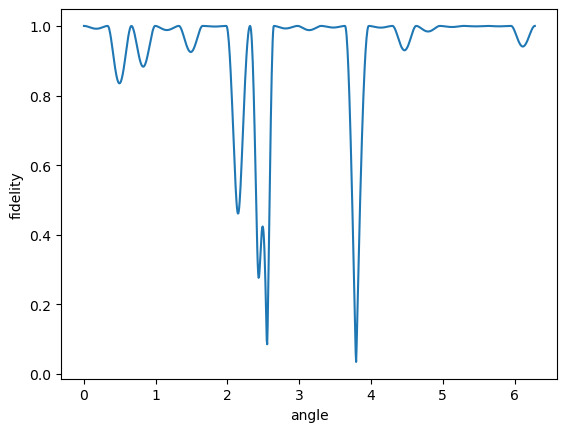

In [9]:
plt.plot(x,y)
plt.xlabel("angle")
plt.ylabel("fidelity")

In [10]:
mean_coeffs = np.mean(coefficients,axis=0)

def getLossFidelity(dt, H0, H_ops,target,mean):
    """
    Get an optimizable fidelity function for a set of pulses
    (Float) dt: Time increment
    (np.matrix) H0: The drift Hamiltonian
    (List[np.matrix]) H_ops: The control Hamiltonians.
    (np.matrix) target: The target state
    """
    def loss(coeffs):
        global iterations
        pulses = np.split(coeffs,len(H_ops))
        U=evolve(pulses, dt, H0, H_ops)
        fidelity = np.abs(np.trace(U.conjugate().transpose()@target))/len(target)
        return  1 - 1 * fidelity + 0.1 * np.linalg.norm(coeffs - mean)
    return loss 

In [11]:
new_coefficients = []
new_fidelities = []
for theta in np.linspace(0,2*np.pi,20):
    u0 = np.random.rand(N*len(H_ops)) * 2 * np.pi * 0.05 #make a random array to start out
    u0=np.convolve(np.ones(10)/10, u0,mode='same') #smooths the input
    result = scipy.optimize.minimize(fun = getLossFidelity(dt=dt, H0=H0, H_ops=H_ops,target=excitation(theta),mean=mean_coeffs)
                        ,x0=u0
                     )
    new_coefficients.append(result.x)
    new_fidelities.append(-1*result.fun)
    print("------------")
    print("Angle "+str(theta))
    print("Loss "+str(result.fun))
    f=-1 * getFidelity(dt=dt, H0=H0, H_ops=H_ops,target=excitation(theta))(result.x)
    print("Fidelity "+str(f))


------------
Angle 0.0
Loss 0.06712857066798333
Fidelity 0.9894801956948797
------------
Angle 0.3306939635357677
Loss 0.08489921215855349
Fidelity 0.9786619028532595
------------
Angle 0.6613879270715354
Loss 0.11903958757582993
Fidelity 0.9807268345427713
------------
Angle 0.992081890607303
Loss 0.14609916823203953
Fidelity 0.9849719064810125
------------
Angle 1.3227758541430708
Loss 0.15752847338133474
Fidelity 0.9890158099920212
------------
Angle 1.6534698176788385
Loss 0.157829470799784
Fidelity 0.9918773449643444
------------
Angle 1.984163781214606
Loss 0.15464678801047346
Fidelity 0.992338414927815
------------
Angle 2.3148577447503738
Loss 0.296781275511019
Fidelity 0.9965274306878464
------------
Angle 2.6455517082861415
Loss 0.19337942983047582
Fidelity 0.995283485671093
------------
Angle 2.9762456718219092
Loss 0.18963167020168953
Fidelity 0.9959279546111505
------------
Angle 3.306939635357677
Loss 0.1883700057703874
Fidelity 0.9964611907612984
------------
Angle 3.637

In [12]:
new_coefficients = np.array(new_coefficients)

In [13]:
x=np.linspace(0,2*np.pi,1000)
y=[]
for i in x:
    y.append(-1 * getFidelity(dt, H0, H_ops,excitation(i))(interpolate(i,new_coefficients)))

Text(0, 0.5, 'fidelity')

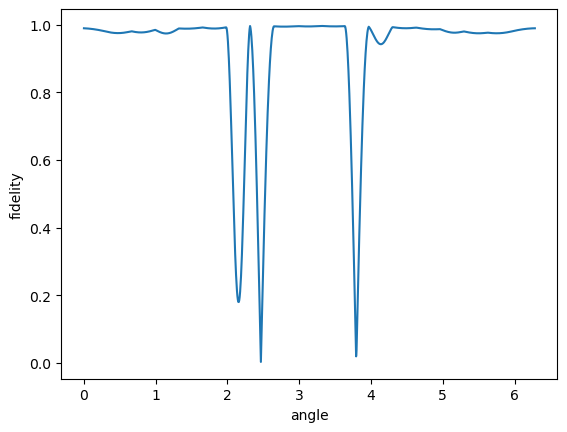

In [14]:
plt.plot(x,y)
plt.xlabel("angle")
plt.ylabel("fidelity")

In [15]:
mean_coeffs = np.mean(new_coefficients,axis=0)
newer_coefficients = []
newer_fidelities = []
for theta in np.linspace(0,2*np.pi,20):
    u0 = np.random.rand(N*len(H_ops)) * 2 * np.pi * 0.05 #make a random array to start out
    u0=np.convolve(np.ones(10)/10, u0,mode='same') #smooths the input
    result = scipy.optimize.minimize(fun = getLossFidelity(dt=dt, H0=H0, H_ops=H_ops,target=excitation(theta),mean=mean_coeffs)
                        ,x0=u0
                     )
    newer_coefficients.append(result.x)
    newer_fidelities.append(-1*result.fun)
    print("------------")
    print("Angle "+str(theta))
    print("Loss "+str(result.fun))
    f=-1 * getFidelity(dt=dt, H0=H0, H_ops=H_ops,target=excitation(theta))(result.x)
    print("Fidelity "+str(f))


------------
Angle 0.0
Loss 0.08180613543293341
Fidelity 0.9885592394071454
------------
Angle 0.3306939635357677
Loss 0.09411036666710715
Fidelity 0.9860318751516632
------------
Angle 0.6613879270715354
Loss 0.11636954426875279
Fidelity 0.986682720543658
------------
Angle 0.992081890607303
Loss 0.13801480077656178
Fidelity 0.9880500946707854
------------
Angle 1.3227758541430708
Loss 0.15194112767640136
Fidelity 0.9884989036878317
------------
Angle 1.6534698176788385
Loss 0.1531382705099281
Fidelity 0.9913711705850324
------------
Angle 1.984163781214606
Loss 0.1483658355730325
Fidelity 0.9921688481906692
------------
Angle 2.3148577447503738
Loss 0.14036403981043982
Fidelity 0.9941288961589142
------------
Angle 2.6455517082861415
Loss 0.16236936919709558
Fidelity 0.9946725193399738
------------
Angle 2.9762456718219092
Loss 0.16110437185999105
Fidelity 0.9953816765361596
------------
Angle 3.306939635357677
Loss 0.16119905508591442
Fidelity 0.9959208126467374
------------
Angle 3

In [16]:
newer_coefficients = np.array(newer_coefficients)
x=np.linspace(0,2*np.pi,1000)
y=[]
for i in x:
    y.append(-1 * getFidelity(dt, H0, H_ops,excitation(i))(interpolate(i,newer_coefficients)))

Text(0, 0.5, 'fidelity')

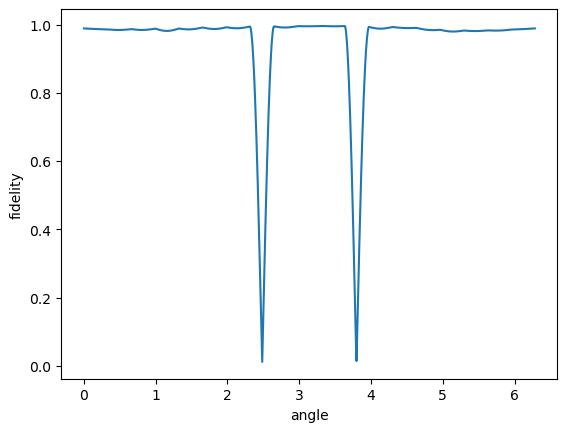

In [17]:
plt.plot(x,y)
plt.xlabel("angle")
plt.ylabel("fidelity")

In [18]:
data = list(zip(x,y))
data.sort(key = lambda v : v[1])
theta0 = data[0][0]
theta1 = data[1][0]

<Figure size 800x1200 with 0 Axes>

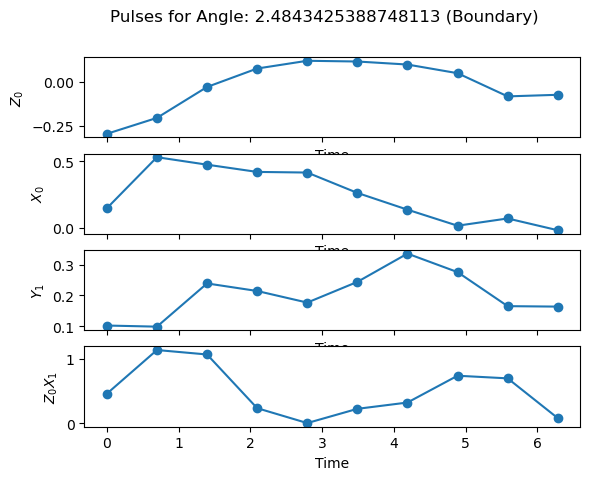

In [19]:
theta  = theta0
coeffs = np.split(interpolate(theta,newer_coefficients),len(H_ops))
plt.figure(figsize=(8,12))
f, ax = plt.subplots(4, sharex=True)
f.suptitle('Pulses for Angle: '+str(theta) + " (Boundary)")
for i in range(4):
    ax[i].plot(np.linspace(0,2*np.pi,10),coeffs[i],'-o')
    ax[i].set(ylabel = H_labels[i],xlabel = 'Time')


<Figure size 800x1200 with 0 Axes>

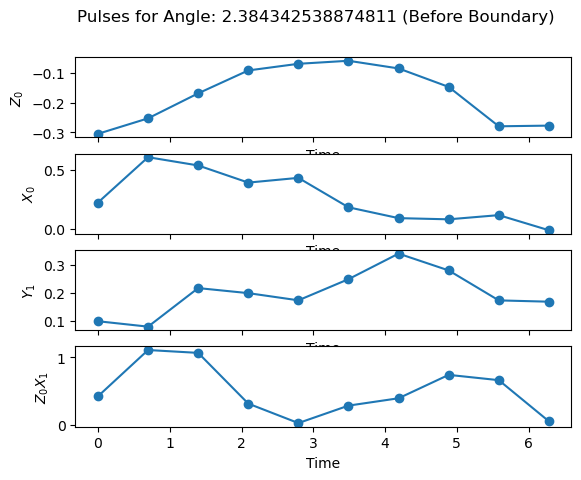

In [20]:
theta  =theta0 - 0.1
coeffs = np.split(interpolate(theta,newer_coefficients),len(H_ops))
plt.figure(figsize=(8,12))
f, ax = plt.subplots(4, sharex=True)
f.suptitle('Pulses for Angle: '+str(theta) + " (Before Boundary)")
for i in range(4):
    ax[i].plot(np.linspace(0,2*np.pi,10),coeffs[i],'-o')
    ax[i].set(ylabel = H_labels[i],xlabel = 'Time')


<Figure size 800x1200 with 0 Axes>

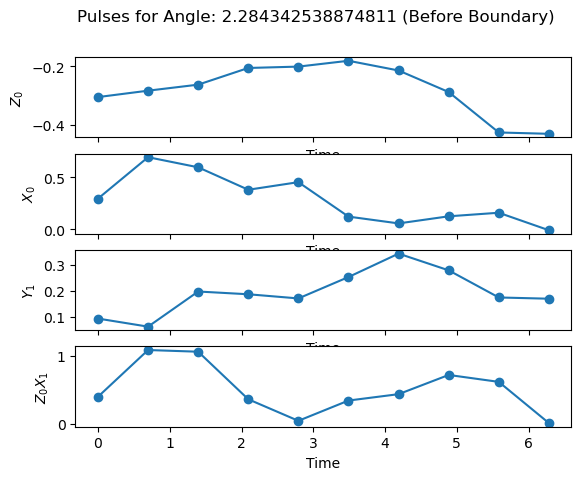

In [21]:
theta  =theta0 - 0.2
coeffs = np.split(interpolate(theta,newer_coefficients),len(H_ops))
plt.figure(figsize=(8,12))
f, ax = plt.subplots(4, sharex=True)
f.suptitle('Pulses for Angle: '+str(theta) + " (Before Boundary)")
for i in range(4):
    ax[i].plot(np.linspace(0,2*np.pi,10),coeffs[i],'-o')
    ax[i].set(ylabel = H_labels[i],xlabel = 'Time')


<Figure size 800x1200 with 0 Axes>

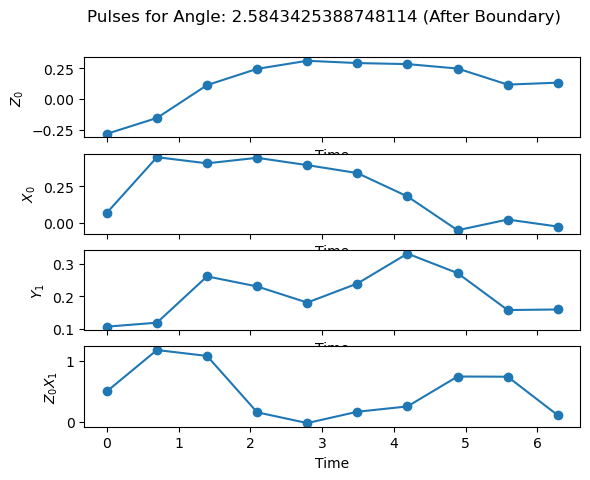

In [22]:
theta  =theta0 + 0.1
coeffs = np.split(interpolate(theta,newer_coefficients),len(H_ops))
plt.figure(figsize=(8,12))
f, ax = plt.subplots(4, sharex=True)
f.suptitle('Pulses for Angle: '+str(theta) + " (After Boundary)")
for i in range(4):
    ax[i].plot(np.linspace(0,2*np.pi,10),coeffs[i],'-o')
    ax[i].set(ylabel = H_labels[i],xlabel = 'Time')


<Figure size 800x1200 with 0 Axes>

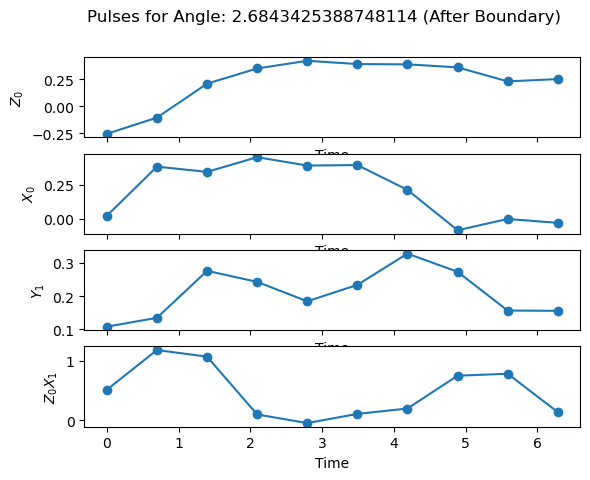

In [23]:
theta  =theta0 + 0.2
coeffs = np.split(interpolate(theta,newer_coefficients),len(H_ops))
plt.figure(figsize=(8,12))
f, ax = plt.subplots(4, sharex=True)
f.suptitle('Pulses for Angle: '+str(theta) + " (After Boundary)")
for i in range(4):
    ax[i].plot(np.linspace(0,2*np.pi,10),coeffs[i],'-o')
    ax[i].set(ylabel = H_labels[i],xlabel = 'Time')


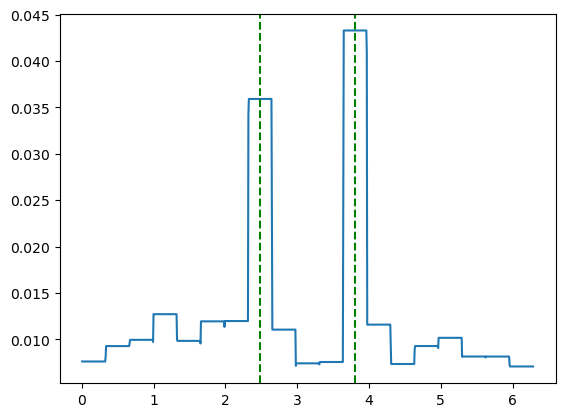

In [24]:
x=np.linspace(0,2*np.pi,1000)
y=[]
for i in range(1,len(x)):
    current = interpolate(x[i],newer_coefficients)
    prev =   interpolate(x[i-1],newer_coefficients)
    y.append(np.linalg.norm(current-prev))
plt.plot(x[1:],y)
plt.axvline(x=theta0,color='g',linestyle = 'dashed')
plt.axvline(x=theta1,color='g',linestyle = 'dashed')

In [25]:
coeffs0  = np.array([newer_coefficients[i] for i in range(20) if np.linspace(0,2*np.pi,20)[i]<theta0])
coeffs1  = np.array([newer_coefficients[i] for i in range(20) if theta0<np.linspace(0,2*np.pi,20)[i]<theta1])
coeffs2  = np.array([newer_coefficients[i] for i in range(20) if theta1<np.linspace(0,2*np.pi,20)[i]])

In [26]:
print("One sided θ1 Fidelity: "+str(-1 * getFidelity(dt, H0, H_ops,excitation(theta0))(interpolate(theta0,coeffs0))))
print("One sided θ2 Fidelity: "+str(-1 * getFidelity(dt, H0, H_ops,excitation(theta1))(interpolate(theta1,coeffs1))))

One sided θ1 Fidelity: 0.9902455711532385
One sided θ2 Fidelity: 0.986601799425654
